In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [52]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [53]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

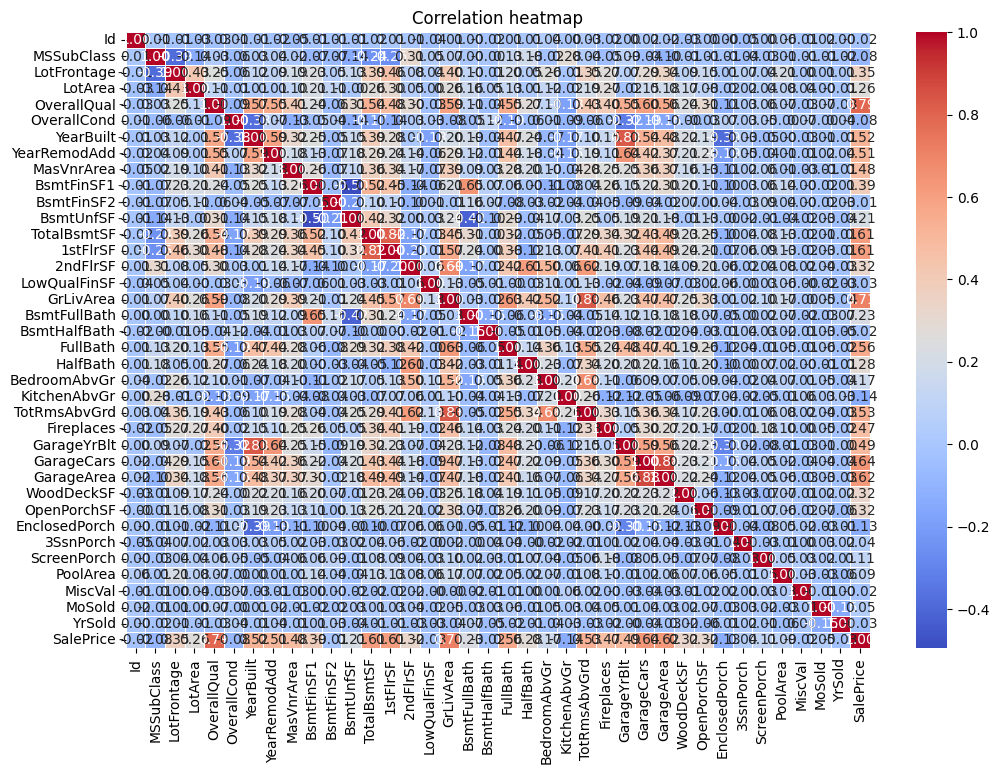

In [55]:
correlation_matrix = train.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation heatmap")
plt.show()

In [56]:
# Set correlation threshold
threshold = 0.7

# Create a mask for absolute correlations above threshold
high_corr = correlation_matrix.abs() > threshold

# Extract correlated pairs (excluding self-correlations)
correlated_pairs = []

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and high_corr.loc[idx, col]:
            correlated_pairs.append((idx, col, correlation_matrix.loc[idx, col]))

# Convert to DataFrame for easier viewing
corr_df = pd.DataFrame(correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

# Drop duplicate pairs (A,B) == (B,A)
corr_df = corr_df.sort_values(by="Correlation", ascending=False).drop_duplicates(subset=["Correlation"])

print("\n===== Highly Correlated Feature Pairs =====")
print(corr_df)


===== Highly Correlated Feature Pairs =====
      Feature 1    Feature 2  Correlation
8    GarageArea   GarageCars     0.882475
1   GarageYrBlt    YearBuilt     0.825667
4  TotRmsAbvGrd    GrLivArea     0.825489
2      1stFlrSF  TotalBsmtSF     0.819530
0     SalePrice  OverallQual     0.790982
5     SalePrice    GrLivArea     0.708624


In [57]:
# Features to drop
features_to_drop = ["GarageArea", "GarageYrBlt", "1stFlrSF"]

# Drop from train and test in place
train.drop(columns=features_to_drop, inplace=True)
test.drop(columns=[f for f in features_to_drop if f in test.columns], inplace=True)

# Check remaining columns
print("Train columns after drop:")
print(train.columns)
print("\nTest columns after drop:")
print(test.columns)


Train columns after drop:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
     

We created a correlation matrix of all of the numeric (non-categorial)
variables. There are 6 pairs of features with an absolute value
correlation higher than 0.7.

From the above table, we would want to choose only Feature 1 or Feature
2 to avoid high multicollinearity in our model.

In [58]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(train.select_dtypes(include='number')))
print((z_scores > 3).sum())

620


In [59]:
# Compute absolute z-scores
numeric_train = train.select_dtypes(include='number')

z_scores = np.abs(stats.zscore(numeric_train, nan_policy='omit'))

# Convert to DataFrame
z_df = pd.DataFrame(z_scores, columns=numeric_train.columns)

# Threshold
threshold = 3

# Boolean mask for outliers
outlier_mask = (z_df > threshold)

# Count outliers per column
outlier_counts = outlier_mask.sum().sort_values(ascending=False)

print("\n===== Outlier Counts per Column =====")
print(outlier_counts[outlier_counts > 0])

# 🔍 Print column names that actually have outliers
outlier_columns = outlier_counts[outlier_counts > 0].index.tolist()
print("\nColumns with outliers:")
print(outlier_columns)


===== Outlier Counts per Column =====
BsmtHalfBath     82
KitchenAbvGr     68
ScreenPorch      55
EnclosedPorch    51
BsmtFinSF2       50
MasVnrArea       32
MSSubClass       30
OverallCond      28
OpenPorchSF      27
3SsnPorch        23
WoodDeckSF       22
SalePrice        22
LowQualFinSF     20
GrLivArea        16
BsmtFullBath     16
BedroomAbvGr     14
LotArea          13
HalfBath         12
TotRmsAbvGrd     12
LotFrontage      12
BsmtUnfSF        11
TotalBsmtSF      10
MiscVal           8
PoolArea          7
YearBuilt         6
BsmtFinSF1        6
Fireplaces        5
2ndFlrSF          4
OverallQual       2
dtype: int64

Columns with outliers:
['BsmtHalfBath', 'KitchenAbvGr', 'ScreenPorch', 'EnclosedPorch', 'BsmtFinSF2', 'MasVnrArea', 'MSSubClass', 'OverallCond', 'OpenPorchSF', '3SsnPorch', 'WoodDeckSF', 'SalePrice', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BedroomAbvGr', 'LotArea', 'HalfBath', 'TotRmsAbvGrd', 'LotFrontage', 'BsmtUnfSF', 'TotalBsmtSF', 'MiscVal', 'PoolArea', '

In [60]:
# # outliers
# train.hist(bins=30, figsize=(15,10))
# plt.show()

# for col in train.select_dtypes(include='number').columns:
#     sns.boxplot(x=train[col])
#     plt.title(col)
#     plt.show()

In [61]:
# Possible features to add:
# Total finished basement square feet:
# BsmtFinSF1 + BsmtFinSF2.

# Total sqft (above and below grade)
# Total finished basement square feet + GrLivArea.

# Can remove 1stFlrSF
train['total_BsmtFin_sqft'] = train['BsmtFinSF1'] + train['BsmtFinSF2']
train['total_sqft'] = train['total_BsmtFin_sqft'] + train['GrLivArea']